In [1]:
from typing import Annotated
from typing_extensions import TypedDict
from typing import TypedDict, Literal, List, Union

import langgraph
from langgraph.graph import StateGraph
from langgraph.graph.message import add_messages
from langgraph.prebuilt import ToolNode, tools_condition

from langchain_core.tools import tool
from langchain_openai import ChatOpenAI, OpenAIEmbeddings
from langchain_core.messages import HumanMessage, SystemMessage,ToolMessage
from langchain_core.pydantic_v1 import BaseModel, Field
from langchain_core.prompts import ChatPromptTemplate
from langgraph.checkpoint.sqlite import SqliteSaver

import json
from IPython.display import Image, display

import os
from langchain_qdrant import QdrantVectorStore
from qdrant_client import QdrantClient
from qdrant_client.http.models import Distance, VectorParams
from tqdm import tqdm
from dotenv import load_dotenv

/Users/debasmitroy/Desktop/rakuten-codes/final/ai-backend-0/.venv/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
load_dotenv("./.env")

True

## Initializing Vector Store

In [3]:
def get_category_wise_vector_store():
    client = QdrantClient(url=os.getenv("QDRANT_URL"),api_key=os.getenv("QDRANT_API_KEY"))
    collections_dict = client.get_collections().dict()
    all_collections = [collection['name'] for collection in collections_dict['collections']]
    category_wise_vector_store = {}
    for category in tqdm(all_collections):
        category_wise_vector_store[category] = QdrantVectorStore(
            client=client,
            collection_name=category,
            embedding=OpenAIEmbeddings(model="text-embedding-3-large"),
        )
    return category_wise_vector_store

In [4]:
CATEGORY_WISE_VECTOR_STORE = get_category_wise_vector_store()

100%|██████████| 27/27 [00:34<00:00,  1.27s/it]


## Engines

In [5]:
class LangchainJSONEngine:
    def __init__(self, sampleBaseModel: BaseModel, systemPromptText: str=None, humanPromptText: str=None):
        self.llm = llm = ChatOpenAI(model="gpt-3.5-turbo", temperature=0)
        self.structured_llm = llm.with_structured_output(sampleBaseModel)
        
        if systemPromptText is None:
            self.systemPromptText = """
            You are an AI assistant. You are helping a user with a task. The user is asking you questions and you are answering them.
            """
        else:
            self.systemPromptText = systemPromptText

        if humanPromptText is None:
            self.HumanPromptText = """
            Human: {query}
            """
        else:
            self.humanPromptText = humanPromptText

        self.prompt = ChatPromptTemplate.from_messages(
            [("system", self.systemPromptText), ("human", "Query:\n\n {query}")])
        
        self.micro_agent = self.prompt | self.structured_llm

    def run(self, query: str):
        result = self.micro_agent.invoke({
            "query": query
        }) 
        return result
    

class LangchainSimpleEngine:
    def __init__(self, tools:List[tool]=[], systemPromptText: str=None, humanPromptText: str=None):
        self.llm = llm = ChatOpenAI(model="gpt-3.5-turbo", temperature=0)
        self.tools = tools
        
        if len(tools) == 0:
            self.llm_with_tools = llm
        else:
            self.llm_with_tools = llm.bind_tools(tools)
            
        if systemPromptText is None:
            self.systemPromptText = """
            You are an AI assistant. You are helping a user with a task. The user is asking you questions and you are answering them.
            """
        else:
            self.systemPromptText = systemPromptText

        if humanPromptText is not None: 
            print("Skipping human prompt text ...")

    def run(self, query: str):
        messages = [
            SystemMessage(self.systemPromptText),
            HumanMessage(content=query)
        ]
        level1_result = self.llm_with_tools.invoke(messages)
        if len(level1_result.tool_calls) == 0:
            print("No tools to run ...")
            return level1_result
        else:
            print("Running tools ...")
            for tool_call in level1_result.tool_calls:
                tool_output = tool_call.invoke()
                messages.append(ToolMessage(tool_output, tool_call_id=tool_call["id"]))
            level2_result = self.llm_with_tools.invoke(messages)
            return level2_result

## Pydantics

In [6]:
class SituationalRequirement1(BaseModel):
    clothing: bool = Field(description="Whether clothing products are relevant to the user's situation.")
    bags_wallets_belts: bool = Field(description="Whether bags, wallets, and belts are relevant to the user's situation.")
    jewellery: bool = Field(description="Whether jewellery products are relevant to the user's situation.")
    beauty_and_personal_care: bool = Field(description="Whether beauty and personal care products are relevant to the user's situation.")
    watches: bool = Field(description="Whether watches are relevant to the user's situation.")
    sunglasses: bool = Field(description="Whether sunglasses are relevant to the user's situation.")
    sports_fitness: bool = Field(description="Whether sports and fitness products are relevant to the user's situation.")
    health_personal_care_appliances: bool = Field(description="Whether health and personal care appliances are relevant to the user's situation.")
    home_decor_festive_needs: bool = Field(description="Whether home decor and festive needs are relevant to the user's situation.")
    home_furnishing: bool = Field(description="Whether home furnishing products are relevant to the user's situation.")
    kithen_dining: bool = Field(description="Whether kitchen and dining products are relevant to the user's situation.")
    homes_kitchen: bool = Field(description="Whether home and kitchen products are relevant to the user's situation.")

In [7]:
class SituationalRequirement2(BaseModel):
    furniture: bool = Field(description="Whether furniture products are relevant to the user's situation.")
    pet_supplies: bool = Field(description="Whether pet supplies are relevant to the user's situation.")
    pens_stationery: bool = Field(description="Whether pens and stationery products are relevant to the user's situation.")
    automotive: bool = Field(description="Whether automotive products are relevant to the user's situation.")
    tools_hardware: bool = Field(description="Whether tools and hardware products are relevant to the user's situation.")
    baby_care: bool = Field(description="Whether baby care products are relevant to the user's situation.")
    mobile_accessories: bool = Field(description="Whether mobile accessories are relevant to the user's situation.")
    computers: bool = Field(description="Whether computer products are relevant to the user's situation.")
    cameras_accessories: bool = Field(description="Whether cameras and accessories are relevant to the user's situation.")
    gaming: bool = Field(description="Whether gaming products are relevant to the user's situation.")
    home_improvement: bool = Field(description="Whether home improvement products are relevant to the user's situation.")
    home_entertainment: bool = Field(description="Whether home entertainment products are relevant to the user's situation.")
    budget_value : float = Field(description="The budget value, the user has for the products. If the user has not specified any budget, then the value is 10000.00")

In [8]:
# class Budget(BaseModel):
#     budget_value : float = Field(description="The budget value in INR.")

In [9]:
class UserRequirement(BaseModel):
    requirement_list: List[str] = Field(description="List of requirements that the user has. Each requirement should be detailed and unique.")
    price_lower_bound: float = Field(description="The lower bound of the price range that the user is looking for in INR. Default: 0")
    price_upper_bound: float = Field(description="The upper bound of the price range that the user is looking for in INR. Default: 100000")

In [10]:
class RequirementFullfilled(BaseModel):
    is_fullfilled: bool = Field(description="Whether the user's requirements are fullfilled.")

In [11]:
class RequirementStatus(BaseModel):
    satisfaction_status: bool = Field(description="Whether the user is very satisfied with all the requirements.")

In [12]:
class AskingsForNewProduct(BaseModel):
    asking_for_new_product: bool = Field(description="Whether the user is asking for a new/another type of product.")

In [108]:
class MoveToPlace(BaseModel):
    move_to_place: bool = Field(description="Whether the user wants to move to a new place.")

class NewPlaceNameAndRequirement(BaseModel):
    new_place_name: str = Field(description="The name of the new place where the user wants to move to.")
    meidcal_store_keys: str = Field(description="Default: Any essential medical store where the user can get medical supplies.")
    grocery_store_keys: str = Field(description="Default: Any grocery store where the user can get groceries.")
    resturants_keys: str = Field(description="Any special cuisine resturants where the user can get food. Default: Any resturants.")

## State

In [115]:
class AgentState(TypedDict):
    cur_state: str
    messages: Annotated[list, add_messages]
    requirements: dict = {}
    first_level_chosen: List[str] = []
    first_level_not_chosen: List[str] = []
    mode: str = "idle"
    recently_added: List[str] = []
    CATEGORY_WISE_VECTOR_STORE: dict
    budget: float = 10000.00
    new_place_req:dict = {}

## Agent Utils

In [367]:
def welcome(state:AgentState)->AgentState:
    msg = SystemMessage("Welcome to the AI assistant. I am here to help you with your shopping needs. Tell me about your situation and I will suggest products accordingly. You may also suggest a budget of your cart ...")
    print(msg.content)
    state['messages'].append(msg)
    # print(f"Current messages: {state['messages']}")
    return state


def secondary_welcome(state:AgentState)->AgentState:
    msg = SystemMessage(f"Hi looks like you are looking for some {state['cur_state']} products. I can help you with that. Tell me about your requirements and I will suggest products accordingly. You may also suggest a price range.")
    print(msg.content)
    print("state['requirements'][state['cur_state']]: ",state['requirements'][state['cur_state']])
    state['requirements'][state['cur_state']]['thread_conversation'].append(msg)
    return state

In [368]:
def exit_from_requirements(state:AgentState)->AgentState:
    print("<< Exiting from requirements >>")
    msg = SystemMessage(f"Final requirements:{state['first_level_chosen']}")
    print(msg.content)
    state['messages'].append(msg)

    print(f"Requirements: {state['requirements']}")
    for req in state['first_level_chosen']:
        state['requirements'][req] = {
            "secondary_status": "new requirement",
            "list_of_requirements": [[]],
            "list_of_products": [],
            "thread_conversation":[],
            "price_lower_bounds": [0.],
            "price_upper_bounds": [100000.]
        }
        print(f"Added {req} to the requirements list.")

    return state

def exit_from_requirements_secondary(state:AgentState)->AgentState:
    print("<< Exiting from secondary requirements >>")
    print(f"Exiting category {state['cur_state']} ...")
    msg = SystemMessage(f"Final requirements:{state['first_level_chosen']}")
    print(msg.content)
    # state['messages'].append(msg)
    state['requirements'][state['cur_state']]['secondary_status'] = "completed"
    return state

def final_exit(state:AgentState)->AgentState: 
    print("<< Exiting from the conversation >>")
    # Clearing all threads
    state['cur_state'] = "exit"
    for key in state['requirements']:
        state['requirements'][key]['thread_conversation'] = []
    msg = SystemMessage(f"So finally we have the following requirements:\n {json.dumps(state['requirements'], indent=4)}")
    print(msg.content)
    state['messages'].append(msg)
    return state

In [369]:
def generate_situational_requirements(user_situation: str,update_mode=False):
    """ 
    This tool generates situational requirements based on the user's situation. 
    """

    systemPromptText = """You are an AI assistant. 
    You are helping a user who is looking for products on an e-commerce platform. 
    He/she will tell you about his/her situation and you will suggest products accordingly those perfectly fit his/her situational requirements.
    You are given a list of possible categories, you have to determine whether products from these categories are relevant to the user's situation or not.
    ONLY Choose those categories which are very much relevant to the user's situation.
    """

    if not update_mode:
        query = f"""
        User: I am looking for products on an e-commerce platform.
        My current situation is: {user_situation}
        """
    else:
        query=f"""
        User: These are previous conversation messages.
        {user_situation}
        Now determine the situational requirements based on the user's situation.
        """

    engine1 = LangchainJSONEngine(SituationalRequirement1, systemPromptText=systemPromptText)
    engine2 = LangchainJSONEngine(SituationalRequirement2, systemPromptText=systemPromptText)

    result1 = engine1.run(query).dict()
    result2 = engine2.run(query).dict()
    budget_value = result2['budget_value']
    del result2['budget_value']
    result1.update(result2)

    return result1, budget_value


def generate_secondary_requirements(chat_conversation):
    """
    This tool generates secondary requirements based on the user's requirements.
    """

    systemPromptText = """You are an AI assistant. 
    You are helping a user who is looking for products on an e-commerce platform. 
    Your task is to determine the user's requirements based on the conversation.
    Generate a list of detailed requirements that the user has. 
    You also have to determine the price range that the user is looking for. Make the requirements very unique, detailed, and specific.

    Example: For a clothing product. [Requirement 1: The product should be of a specific brand. Requirement 2: The product should be of a specific color. Requirement 3: The product should be of a specific size.]
    price_lower_bound: 0
    price_upper_bound: 10000
    """

    query = f"""
    Chat conversation: {chat_conversation}
    """

    engine = LangchainJSONEngine(UserRequirement, systemPromptText=systemPromptText)
    result = engine.run(query).dict()
    
    return result

In [370]:
def summarize_chosen_categories(first_level_chosen:List[str]):
    systemPromptText = """You are an AI assistant.
    You are helping a user who is looking for products on an e-commerce platform. 
    There are some AI suggested categories that are relevant to the user's situation.
    You have to summarize the chosen categeroies and tell the user about the categories.
    You all also if he/she wants to add or remove any categories. Also mention if there is any budget range available or mentioned by the user.
    Also, you have to ask the user if he/she wants to proceed to the product suggestion phase if the chosen categories are correct.
    """

    query = f"""
    Some AI suggested chosen categories: {first_level_chosen}
    """

    engine = LangchainSimpleEngine(systemPromptText=systemPromptText)
    result = engine.run(query)

    return result.content


def summarize_secondary_requirements(requirement_list:List[str]):

    systemPromptText = """You are an AI assistant.
    You are helping a user who is looking for products on an e-commerce platform. 
    There are some AI suggested requirements that based on the user's chat conversation with the AI.

    You have to summarize the chosen requirements and tell the user about the requirements.
    You also tell if he/she wants to add or remove any requirements. Tell the user if he/she wants to modify the price range.
    Also, you have to ask the user if he/she wants to 
        1. Add a new product under same category
        2. Completed with this category and move to the next category

    """

    query = f"""
    Some AI suggested chosen requirements: {requirement_list}
    """

    engine = LangchainSimpleEngine(systemPromptText=systemPromptText)
    result = engine.run(query)

    return result.content

In [371]:
def check_statisfied(state:AgentState)->AgentState:
    print("<< check_statisfied >>")
    chat = "\n".join([f"{msg.type} : {msg.content}" for msg in state['messages']])
    systemPromptText = """You are an AI assistant.
    You are helping a user who is looking for products on an e-commerce platform.
    You read the user's previous conversations and determine whether the user has described all his/her requirements and ready to proceed with the product suggestions.
    
    If the user says 'Lets go ahead ","Ok", "Move on" or similar etc. - You have consider the requirements as fullfilled / satisfied.
   
    """

    query = f"""
    Previous messages: {chat}
    Now tell me, are all the user's requirements fullfilled?
    """

    engine = LangchainJSONEngine(RequirementFullfilled, systemPromptText=systemPromptText)
    result = engine.run(query).dict()
    state['is_fullfilled'] = result['is_fullfilled']

    print(f"Is fullfilled ??????? : {state['is_fullfilled']}")

    return state['is_fullfilled']
    

def check_statisfied_secondary(state:AgentState)->AgentState:
    print("<< check_statisfied_secondary >>")
    chat = "\n".join([f"{msg.type} : {msg.content}" for msg in state['requirements'][state['cur_state']]['thread_conversation']])

    print("(Sec) Chat: ",chat)
    systemPromptText = f"""You are an AI assistant.
    You are helping a human who is looking for {"clothing"} products on an e-commerce platform.
    You read the human's previous conversations and determine the status of the conversation.
    You have to determine whether the user is asking for a new requirement or he/she is satisfied with the current requirements.

    If the user says 'Lets go ahead ","Ok", "Move on" or similar etc. - You have consider the requirements as fullfilled / satisfied.
    """

    query = f"""
    Previous conversations: {chat}
    What is the status of the conversation?
    """

    engine = LangchainJSONEngine(RequirementStatus, systemPromptText=systemPromptText)
    result = engine.run(query).dict()

    state['requirements'][state['cur_state']]['secondary_done'] = "completed" if result['satisfaction_status'] else "new requirement"
    print(f"Is fullfilled (secondary) ??????? : {result}")
    return state['requirements'][state['cur_state']]['secondary_done']


def check_asking_for_new_product_secondary(state:AgentState)->AgentState:
    print("<< check_asking_for_new_product_secondary >>")
    chat = "\n".join([f"{msg.type} : {msg.content}" for msg in state['requirements'][state['cur_state']]['thread_conversation']])
    print("----------------------> >  >> > .",chat)
    print("----!----"*21)
    systemPromptText = """You are an AI assistant.
    You are helping a user who is looking for products on an e-commerce platform.
    You read the user's previous conversations and determine whether the user is interested in a new product.
    """

    query = f"""
    Previous messages: {chat}
    Now tell me, is the user asking for a new product?
    """

    engine = LangchainJSONEngine(AskingsForNewProduct, systemPromptText=systemPromptText)
    result = engine.run(query).dict()

    print(f"Is asking for new product ??????? : {result}")

    if result['asking_for_new_product']:
        state['requirements'][state['cur_state']]['secondary_done'] = "new requirement"

    return 'asking for new product' if result['asking_for_new_product'] else 'completed'

In [372]:
# check_statisfied_secondary("""
#                            system : Hi looks like you are looking for some clothing products. I can help you with that. Tell me about your requirements and I will suggest products accordingly.
# human : I want to go to a wedding party. So i want ethnic wear, jewellery, and beauty products.
# system : Final requirements:['clothing', 'jewellery', 'beauty_and_personal_care']
# human: let go ahead, I need another saree for my office inauguration.               
# """)

In [373]:
def human_node(state:AgentState)->AgentState:
    print("Human node ...")
    # print(f"Current messages: {state['messages']}")
    return state

def human_node_secondary(state:AgentState)->AgentState:
    print("Human node (secondary) ...")
    # print(f"Current messages: {state[state['cur_state']]['thread_conversation']}")
    state['recently_added'] = []
    return state

In [374]:
def refine_requirement(reqs:dict):
    chosen = []
    not_chosen = []
    for key, value in reqs.items():
        if value == True:
            chosen.append(key)
        else:
            not_chosen.append(key)
    return chosen, not_chosen


def ask_ai_first_level_requirements(state:AgentState)->AgentState:
    print("<<< Asking for first level requirements ... >>>")
    previous_messages = state['messages']
    chat = "\n".join([f"{msg.type} : {msg.content}" for msg in previous_messages])
    first_level_requirements,budget_value = generate_situational_requirements(chat,update_mode=True)
    # state['requirements'] = first_level_requirements
    first_level_chosen, first_level_not_chosen = refine_requirement(first_level_requirements)
    state['budget'] = budget_value
    state['first_level_chosen'] = first_level_chosen
    state['first_level_not_chosen'] = first_level_not_chosen
    summarized_ans = summarize_chosen_categories(first_level_chosen)
    print(summarized_ans)
    state['messages'].append(SystemMessage(summarized_ans))
    return state

def ask_ai_secondary_level_requirements(state:AgentState)->AgentState:
    print("<<< Asking for secondary level requirements ... >>>")
    previous_messages = state['requirements'][state['cur_state']]['thread_conversation']
    chat = "\n".join([f"{msg.type} : {msg.content}" for msg in previous_messages])
    secondary_level_requirements = generate_secondary_requirements(chat)
    state['requirements'][state['cur_state']]['list_of_requirements'][-1]=(secondary_level_requirements['requirement_list'])
    state['requirements'][state['cur_state']]['price_lower_bounds'][-1] = secondary_level_requirements['price_lower_bound']
    state['requirements'][state['cur_state']]['price_upper_bounds'][-1] = secondary_level_requirements['price_upper_bound']

    print("-"*20)
    print("price lower bounds: ",state['requirements'][state['cur_state']]['price_lower_bounds'])
    print("price upper bounds: ",state['requirements'][state['cur_state']]['price_upper_bounds'])
    print(secondary_level_requirements['requirement_list'])
    print("-"*20)

    # state['requirements'][state['cur_state']]['thread_conversation'].append(HumanMessage(content=secondary_level_requirements['requirement_list']))
    summarized_ans = summarize_secondary_requirements(secondary_level_requirements['requirement_list'])
    print(summarized_ans)
    state['requirements'][state['cur_state']]['thread_conversation'].append(SystemMessage(summarized_ans))
    return state

def ask_categrory_requirements_from_feedback(primary_chats, category):
    print("<<< Asking for category requirements from feedback ... >>>")
    
    systemPromptText = f"""You are an AI assistant.
    You are helping a user who is looking for products on an e-commerce platform for the {category} category. 
    You have to generate detailed requirements based on the can best suit the user's needs for the {category} category. Then you have to suggest products accordingly.
    Example: If the user has mentioed he is moving to a new hot place. You can suggest him to buy "summer clothes", "sunglasses", "half sleeve shirts" etc.
    for the "clothing" category.  
    
    Make the requirements very unique, detailed, and specific for the uese case.
    """

    query = f"""
    Previous messages: {primary_chats}


    Now tell me, what are your requirements for {category} products?
    """

    engine = LangchainJSONEngine(UserRequirement, systemPromptText=systemPromptText)
    result = engine.run(query).dict()
    
    return result

In [375]:
ask_categrory_requirements_from_feedback("""
                                         USer: I am looking for products on an e-commerce platform. I am moving to paris in winter.
                                         System:You may need clothing and jwelleries
                                            User: Yes, I need clothing and jwelleries
                                            System: Final requirements:['clothing', 'jewellery']
                                         User: Go Aheadd!
                                         ""","clothing")

<<< Asking for category requirements from feedback ... >>>


{'requirement_list': ['Winter coats',
  'Scarves',
  'Boots',
  'Thermal wear',
  'Hats',
  'Gloves'],
 'price_lower_bound': 0.0,
 'price_upper_bound': 100000.0}

In [401]:
def iteration_start(state:AgentState)->AgentState:
    print("<< Iteration start ... >>")
    state['mode'] = "secondary"
    for req in state['requirements']:
        if state['requirements'][req]['secondary_status'] == "new requirement":
            print(f"Activating {req} ...")
            state['cur_state'] = req
            # state['requirements'][req]['secondary_status'] = "completed"

            reqs_from_feedback = ask_categrory_requirements_from_feedback("\n".join([f"{msg.type} : {msg.content}" for msg in state['messages']]),req)

            stringified_reqs = "\n".join(reqs_from_feedback['requirement_list'])

            print("*"*20)
            print("Req from feedback: ",reqs_from_feedback)
            print("*"*20)

            # TODO
            msg = SystemMessage(f"Hi looks like you are looking for some {state['cur_state']} products. Some requirements may be {stringified_reqs}") # AI generated
            state['requirements'][req]['thread_conversation'].append(msg)

            state['requirements'][state['cur_state']]['list_of_requirements'][-1] = reqs_from_feedback['requirement_list']
            state['requirements'][state['cur_state']]['price_lower_bounds'][-1] = 0 # AI generated
            state['requirements'][state['cur_state']]['price_upper_bounds'][-1] = 100000 # AI generated
            break;
    return state

def req_iterator(state:AgentState)->AgentState:
    print("<< Req iterator ... >>")
    
    for req in state['requirements']:
        if state['requirements'][req]['secondary_status'] == "new requirement":
            return True

    state['cur_state'] = "exit"   
    return False

In [402]:
def dummy_secondary_req_handler(state:AgentState)->AgentState:
    print("<< dummy_secondary_req_handler ... >>")
    print("Dummy secondary req handler ...")
    print(f"Requirements: {state['requirements']}")
    state['requirements'][state['cur_state']]['secondary_status'] = "completed"
    return state

In [403]:
def new_product_handler(state:AgentState)->AgentState:
    print("<< New product handler ... >>")
    state['requirements'][state['cur_state']]['thread_conversation'] = []
    state['requirements'][state['cur_state']]['list_of_requirements'].append([])
    state['requirements'][state['cur_state']]['price_lower_bounds'].append(0.)
    state['requirements'][state['cur_state']]['price_upper_bounds'].append(100000.)
    msg = SystemMessage(f"Do you want to add a new product under the same category or move to the next category?")
    state['requirements'][state['cur_state']]['thread_conversation'].append(msg)
    print("%"*12)
    print(f"Requirements: {state['requirements']}")
    print("%"*12)
    return state

In [404]:
def sort_by_price_relevance(product_doc_list, price_lower_bound, price_upper_bound):
    product_doc_list = product_doc_list.copy()
    # Calculate the midpoint of the price range
    price_midpoint = (price_lower_bound + price_upper_bound) / 2
    def relevance(product_doc):
        price = product_doc.metadata['discounted_price']
        return abs(price - price_midpoint)
    sorted_product_doc_list = sorted(product_doc_list, key=relevance)
    # sorted_product_doc_list.reverse()
    
    return sorted_product_doc_list


def product_search(state:AgentState)->AgentState:
    print("<< Product search ... >>")
    cur_reqs = state['requirements'][state['cur_state']]['list_of_requirements'][-1]
    price_lower_bound = state['requirements'][state['cur_state']]['price_lower_bounds'][-1]
    price_upper_bound = state['requirements'][state['cur_state']]['price_upper_bounds'][-1]
    # Elastic search for products based on the requirements
    # Currently dummy random products
    # product_list = [f"{state['cur_state']}_{len(state['requirements'][state['cur_state']]['list_of_requirements'])}_{i}" for i in range(5)]
    global CATEGORY_WISE_VECTOR_STORE
    print("Searching products with reqs: ","\n- ".join(cur_reqs))
    product_doc_list = CATEGORY_WISE_VECTOR_STORE[state['cur_state']].similarity_search("\n- ".join(cur_reqs),k=10)
    if not(price_lower_bound==0. and price_upper_bound==100000.):
        print("!!!! User is looking for a specific price range !!!!")
        product_doc_list = sort_by_price_relevance(product_doc_list, price_lower_bound, price_upper_bound)
    # discounted_price is the key for each doc for the price
    # Sort the doclist based on the relevanve of price range
    print(f"Showing products for {state['cur_state']} Price range: {price_lower_bound} - {price_upper_bound}")
    # print("Product list: ",product_doc_list)
    product_list = [doc.metadata['uniq_id'] for doc in product_doc_list]

    state['requirements'][state['cur_state']]['list_of_products'].append(product_list)
    state['recently_added'] = product_list
    return state

In [405]:
def check_for_relocation(state:AgentState)->AgentState:
    chats = "\n".join([f"{msg.type} : {msg.content}" for msg in state['messages']])
    print("-p-"*20)
    print("Chats: ",chats)
    print("-p-"*20)
    systemPromptText = """You are an AI assistant.
    You are helping a user who is looking for products on an e-commerce platform. 
    You are given the user's pervious conversation messages. You have to whether the user has a plan to move to a new place/city/country for relocation, travelling etc.
    """

    query = f"""
    Previous messages: {chats}
    Now tell me, is the user planning to move to a new place?
    """

    engine = LangchainJSONEngine(MoveToPlace, systemPromptText=systemPromptText)
    result = engine.run(query).dict()

    print(f"is the user planning to move to a new place??????? : {result}")

    return 'move to new place' if result['move_to_place'] else 'completed'


def extract_new_place(state:AgentState)->AgentState:
    chats = "\n".join([f"{msg.type} : {msg.content}" for msg in state['messages']])
    print("-p-"*20)
    print("Chats: ",chats)
    print("-p-"*20)
    systemPromptText = """You are an AI assistant.
    You are helping a user who is looking for products on an e-commerce platform. 
    You are given the user's pervious conversation messages. You have to extract the new place where the user wants to move.
    You also determine the search keys for essential medical stores, grocery stores.
    If the user has any specific cusine in mind, you have to determine the search keys for resturants.
    The search keys should be very brief.
    """

    query = f"""
    Previous messages: {chats}
    Now extract the new place where the user wants to move. And also the search keys for essential medical stores, grocery stores, and resturants.
    """

    engine = LangchainJSONEngine(NewPlaceNameAndRequirement, systemPromptText=systemPromptText)
    result = engine.run(query).dict()

    return result

In [406]:
def ask_user_newplace_reqs(state:AgentState)->AgentState:
    msg = SystemMessage("It looks like you are planning to move to a new place. You may tell me about the new place and I may suggest you the essential shops and resturants.")
    state['messages'].append(msg)
    return state

def start_for_newplace_check(state:AgentState)->AgentState:
    print("Checking for new place ...")
    return state

def new_place_handler(state:AgentState)->AgentState:
    print("New place handler ...")
    state['mode'] = "idle"
    state['cur_state'] = "new place"

    chat = "\n".join([f"{msg.type} : {msg.content}" for msg in state['messages']])
    print("-p-"*20)
    print("Chats: ",chat)
    print("-p-"*20)

    result = extract_new_place(state)
    state['new_place_req'] = result
    return state

In [407]:
def make_more_interactive_response(old_msg:str):
    print("Making more interactive response ...")
    # USe LangchainSimpleEngine
    systemPromptText = """You are an AI assistant. 
        YOu are given an response from the user.
        You have to make the response more interactive and engaging for a better user experience.
        """
    
    query = f"""
    Old message: {old_msg}

    Now make the response more interactive and engaging.
    """

    engine = LangchainSimpleEngine(systemPromptText=systemPromptText)
    result = engine.run(query)

    return result.content

In [408]:
# sample_state = AgentState(cur_state="welcome", messages=[
#     SystemMessage("Welcome to the AI assistant. I am here to help you with your shopping needs. Tell me about your situation and I will suggest products accordingly."),
#     HumanMessage("I am trying rellocate to Delhi from chennai. I am obsessed with south indian culture"),
#     SystemMessage("Sure. Some possible categories are: clothing, bags_wallets_belts, jewellery, beauty_and_personal_care, watches, sunglasses. Are these categories relevant to your situation?"),
#     # HumanMessage("I choose clothing, bags_wallets_belts, and jewellery."),
#     # SystemMessage("Great! Now let's move on to the next set of categories. Sre sure you want to proceed to product suggestions?"),
#     # HumanMessage("No. I want also want to add beauty_and_personal_care, watches, and sunglasses."),
#     # SystemMessage("Great! Now let's move on to the next set of categories. Sre sure you want to proceed to product suggestions?"),
#     HumanMessage("Uhhm!.")
# ], requirements={})

In [409]:
# state_ = new_place_handler(sample_state)

In [410]:
# state_

In [411]:
# _is_fullfilled = check_statisfied(sample_state)

In [412]:
# _is_fullfilled

## Creating Agent

In [413]:
class MyAgent:
    def __init__(self,thread_id):
        self.config = None
        self.app = None
        self.build(thread_id)

    def draw_workflow(self):
        display(Image(self.app.get_graph(xray=True).draw_mermaid_png()))
    
    def build(self,thread_id):
        workflow = StateGraph(AgentState)
        workflow.add_node("welcome", welcome)
        workflow.add_node("human", human_node)
        workflow.add_node("ask_ai_first_level_requirements", ask_ai_first_level_requirements)
        workflow.add_node("exit_from_first_level_requirements", exit_from_requirements)

        workflow.add_node("iteration_start", iteration_start)
        # workflow.add_node("welcome_secondary", secondary_welcome)
        workflow.add_node("human_secondary", human_node_secondary)
        workflow.add_node("human_secondary_new_prod", human_node_secondary)
        # workflow.add_node("human_new_place", human_node_secondary)
        workflow.add_node("ask_ai_secondary_level_requirements", ask_ai_secondary_level_requirements)
        workflow.add_node("exit_from_requirements_secondary", exit_from_requirements_secondary)


        workflow.add_node("new_product_handler", new_product_handler)
        workflow.add_node("product_search", product_search)
        
        # workflow.add_node("start_for_newplace_check", start_for_newplace_check)
        # workflow.add_node("new_place_handler", new_place_handler)


        workflow.add_node("final_exit", final_exit)

        

        workflow.add_edge("welcome", "human")
        workflow.add_conditional_edges(
            "human", 
            check_statisfied,
            {
                True: "exit_from_first_level_requirements",
                False: "ask_ai_first_level_requirements"
            }
        )
        workflow.add_edge("ask_ai_first_level_requirements", "human")

        workflow.add_edge("exit_from_first_level_requirements", "iteration_start")
        workflow.add_conditional_edges(
            "iteration_start", 
            req_iterator,
            {
                True: "human_secondary",
                False: "final_exit" # here we can add a new node to check for relocation
            }
        )

        # workflow.add_edge("welcome_secondary", "human_secondary")
        workflow.add_conditional_edges(
            "human_secondary", 
            check_statisfied_secondary,
            {
                "new requirement": "ask_ai_secondary_level_requirements",
                "completed": "product_search"
            }
        )

        workflow.add_edge("ask_ai_secondary_level_requirements", "human_secondary")    

        workflow.add_edge("product_search", "exit_from_requirements_secondary")
        workflow.add_edge("exit_from_requirements_secondary", "new_product_handler")
        workflow.add_edge("new_product_handler", "human_secondary_new_prod")
        workflow.add_conditional_edges(
            "human_secondary_new_prod", 
            check_asking_for_new_product_secondary,
            {
                'asking for new product': "ask_ai_secondary_level_requirements",
                'completed': "iteration_start"
            }
        )

        # workflow.add_conditional_edges(
        #     "start_for_newplace_check", 
        #     check_for_relocation,
        #     {
        #         'move to new place': "new_place_handler",
        #         'completed': "final_exit"
        #     }
        # )

        # workflow.add_edge("new_place_handler", "human_new_place")
        # workflow.add_edge("human_new_place", "final_exit")
        workflow.add_edge("final_exit", langgraph.graph.END)

        
        workflow.set_entry_point("welcome")
        with SqliteSaver.from_conn_string(":memory:") as memory:
            app = workflow.compile(
                checkpointer=memory,
                interrupt_before=["human","human_secondary","human_secondary_new_prod"],
            )
        
        self.app = app
        self.config = {"configurable": {"thread_id": str(thread_id)}}
        return app

    
    def get_recent_state_snap(self):
        return self.app.get_state(config=self.config).values.copy()
    
    def get_last_message(self):
        if self.get_recent_state_snap()["mode"] == "secondary":
            return self.get_last_secondary_message()
        snap = self.get_recent_state_snap()
        return snap["messages"][-1]
    
    def get_last_secondary_message(self):
        snap = self.get_recent_state_snap()
        return snap["requirements"][snap["cur_state"]]["thread_conversation"][-1]

    def continue_flow(self, state):
        self.app.invoke(state, config=self.config)
        return self.get_recent_state_snap()

    def resume_with_user_input(self, user_input:str):
        if self.get_recent_state_snap()["mode"] == "secondary":
            print("<<<<<<<<<<<<<<<<< Resuming secondary ...")
            return self.resume_with_user_input_secondary(user_input)
        snap = self.get_recent_state_snap()
        snap["messages"].append(HumanMessage(user_input))
        self.app.update_state(self.config, snap)
        return self.continue_flow(None)
    
    def resume_with_user_input_secondary(self, user_input:str):
        snap = self.get_recent_state_snap()
        snap["requirements"][snap["cur_state"]]["thread_conversation"].append(HumanMessage(user_input))
        self.app.update_state(self.config, snap)
        return self.continue_flow(None)

In [414]:
# config = {"configurable": {"thread_id": "50"}}

In [415]:
my_agent = MyAgent(thread_id=50)

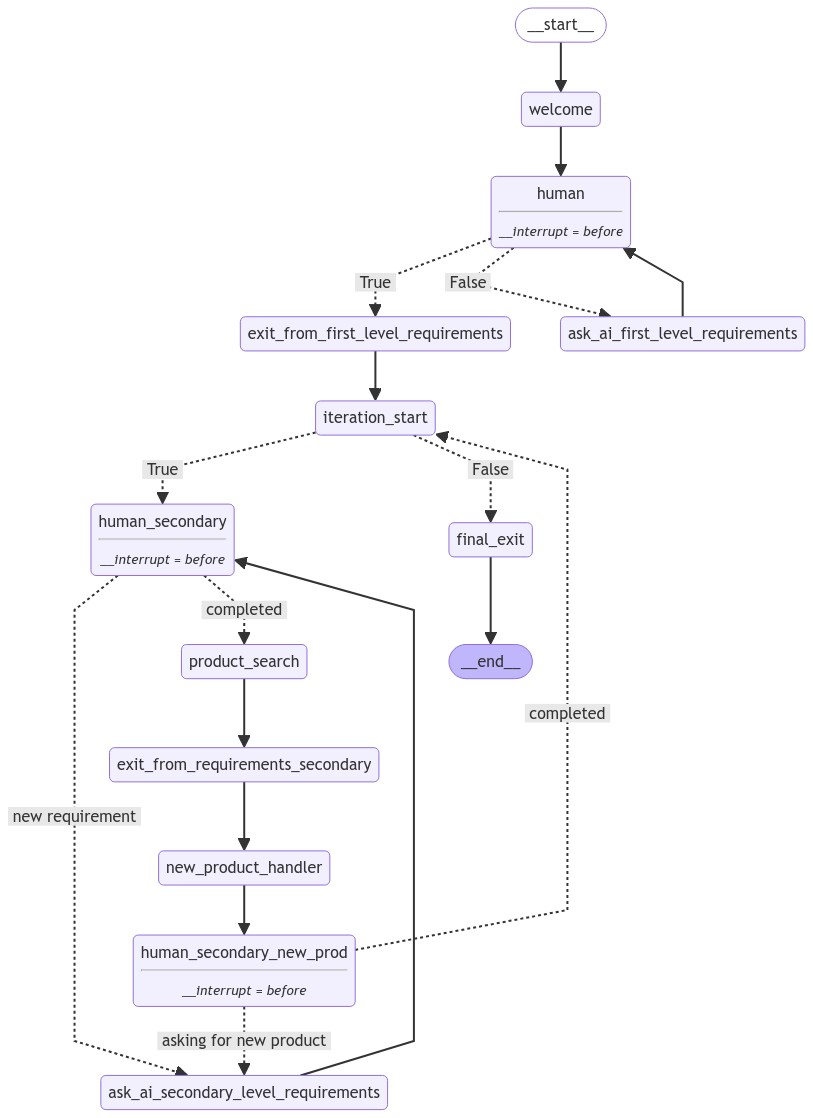

In [416]:
my_agent.draw_workflow()

In [417]:
my_agent.get_recent_state_snap().keys()

dict_keys(['messages'])

In [418]:
snap = my_agent.continue_flow({
    "cur_state": "Requirement Phase",
    "requirements": {},
    "mode":"primary",
    "budget": 100000.00,
})

Welcome to the AI assistant. I am here to help you with your shopping needs. Tell me about your situation and I will suggest products accordingly. You may also suggest a budget of your cart ...


In [419]:
print(my_agent.get_recent_state_snap())

{'cur_state': 'Requirement Phase', 'messages': [SystemMessage(content='Welcome to the AI assistant. I am here to help you with your shopping needs. Tell me about your situation and I will suggest products accordingly. You may also suggest a budget of your cart ...', id='846a13a9-c2cb-47fe-b032-d6b9b29fb9ea')], 'requirements': {}, 'mode': 'primary', 'budget': 100000.0}


In [420]:
# snap = my_agent.resume_with_user_input("Hi! I am planning to go to a party and I want to look cool. I also want to gift something to my friend. It will be on Almora , Uttarakhand")
# snap = my_agent.resume_with_user_input("Hi! I am planning relocate to Bangaluru PG! I am looking for some cool products for my new place.")
snap = my_agent.resume_with_user_input("I want some some sarees for my Mom!")

Human node ...
<< check_statisfied >>


Is fullfilled ??????? : False
<<< Asking for first level requirements ... >>>
No tools to run ...
The chosen category is "clothing." This category includes a wide range of products such as tops, bottoms, dresses, outerwear, and more. Is there any specific type of clothing you are looking for within this category? Do you have a budget range in mind for your clothing purchases? Would you like to add or remove any categories before we proceed to the product suggestion phase?


In [421]:
snap

{'cur_state': 'Requirement Phase',
 'messages': [SystemMessage(content='Welcome to the AI assistant. I am here to help you with your shopping needs. Tell me about your situation and I will suggest products accordingly. You may also suggest a budget of your cart ...', id='846a13a9-c2cb-47fe-b032-d6b9b29fb9ea'),
  HumanMessage(content='I want some some sarees for my Mom!', id='430c421a-6c49-43f6-88b0-8dbc5c43d8f3'),
  SystemMessage(content='The chosen category is "clothing." This category includes a wide range of products such as tops, bottoms, dresses, outerwear, and more. Is there any specific type of clothing you are looking for within this category? Do you have a budget range in mind for your clothing purchases? Would you like to add or remove any categories before we proceed to the product suggestion phase?', id='dc1e8cd1-d6b4-4f2b-b9c8-159b3f23d054')],
 'requirements': {},
 'first_level_chosen': ['clothing'],
 'first_level_not_chosen': ['bags_wallets_belts',
  'jewellery',
  'beaut

In [422]:
# snap = my_agent.resume_with_user_input("Remove Home Entertainment and Bags, Wallets, Belts. And i have a budget arounf 35000")
# snap = my_agent.resume_with_user_input("Remove jwellery too!")
# snap = my_agent.resume_with_user_input("Keep only Home Decor & Festive Needs, remove everytinhg else. And my budget is 50000")

snap = my_agent.resume_with_user_input("Yes!")

Human node ...
<< check_statisfied >>
Is fullfilled ??????? : False
<<< Asking for first level requirements ... >>>


No tools to run ...
The chosen category is "clothing." This category includes a wide range of products such as tops, bottoms, dresses, outerwear, and more. 

Would you like to add or remove any categories? Do you have a specific budget range in mind for your clothing purchases? 

Once you confirm the categories, we can proceed to the product suggestion phase.


In [398]:
print(make_more_interactive_response(my_agent.get_last_message().content))

Making more interactive response ...


No tools to run ...
Great choice on selecting the "clothing" category! 🌟 From trendy tops to stylish bottoms, and everything in between, you're in for a fashion-filled adventure! 

Before we dive into the exciting world of clothing suggestions, do you have any categories you'd like to explore further or perhaps remove? Your preferences matter! 💁‍♀️

Also, setting a budget range can help us tailor our recommendations to suit your style and wallet. Do you have a specific budget in mind for your fabulous fashion finds? 💸

Once you're all set, we'll curate some fantastic product suggestions just for you! Let's make your shopping experience as delightful as possible! 🛍️✨


In [399]:
# snap = my_agent.resume_with_user_input("No! I want to gift some techinical gadgets to my friend. Like a smartwatch, a pair of headphones, and a power bank. Keep the rest of the categories same.")
# snap = my_agent.resume_with_user_input("Add, beauty and personal care, watches, and sunglasses.")

In [423]:
snap = my_agent.resume_with_user_input("Yes! thanks. I am ready to proceed to the product suggestions.")

Human node ...
<< check_statisfied >>


Is fullfilled ??????? : True
<< Exiting from requirements >>
Final requirements:['clothing']
Requirements: {}
Added clothing to the requirements list.
<< Iteration start ... >>
Activating clothing ...
<<< Asking for category requirements from feedback ... >>>
********************
Req from feedback:  {'requirement_list': ['Sarees for Mom', 'Traditional and Elegant Designs', 'Lightweight and Comfortable Fabrics', 'Bright and Vibrant Colors', 'Budget-friendly options', 'Variety of Patterns and Embellishments'], 'price_lower_bound': 1000.0, 'price_upper_bound': 5000.0}
********************
<< Req iterator ... >>


In [424]:
print(my_agent.get_last_message().content)

Hi looks like you are looking for some clothing products. Some requirements may be Sarees for Mom
Traditional and Elegant Designs
Lightweight and Comfortable Fabrics
Bright and Vibrant Colors
Budget-friendly options
Variety of Patterns and Embellishments


In [426]:
snap = my_agent.resume_with_user_input("Go ahead!")

<<<<<<<<<<<<<<<<< Resuming secondary ...


Human node (secondary) ...
<< check_statisfied_secondary >>
(Sec) Chat:  system : Hi looks like you are looking for some clothing products. Some requirements may be Sarees for Mom
Traditional and Elegant Designs
Lightweight and Comfortable Fabrics
Bright and Vibrant Colors
Budget-friendly options
Variety of Patterns and Embellishments
human : Yes sure! Show me some products
system : Chosen requirements:
- Product type: Sarees
- Recipient: Mom
- Design: Traditional and Elegant
- Fabric: Lightweight and Comfortable
- Color: Bright and Vibrant
- Budget: Budget-friendly
- Patterns: Variety of Patterns
- Embellishments: Variety of Embellishments

Do you want to add or remove any requirements? 
Do you want to modify the price range?
Do you want to:
1. Add a new product under the same category
2. Complete this category and move to the next category
human : Go ahead!
Is fullfilled (secondary) ??????? : {'satisfaction_status': True}
<< Product search ... >>
Searching products with reqs:  Produc

In [100]:
# snap = my_agent.resume_with_user_input("I want to got a wedding party. So i want ethnic wear, jewellery, and beauty products. Price should be between 1000 and 5000")
# snap = my_agent.resume_with_user_input("I want this for my grandmother. Show me some sarees for old ladies.")
# snap = my_agent.resume_with_user_input("Golden and pearl")
# snap = my_agent.resume_with_user_input("Platinu and diamond")


snap = my_agent.resume_with_user_input("II am lokking for some potraits! and vase for my home. Price should be between 1000 and 5000")

snap = my_agent.resume_with_user_input(" iam satisified")

<<<<<<<<<<<<<<<<< Resuming secondary ...
Human node (secondary) ...
(Sec) Chat:  system : Hi looks like you are looking for some furniture products. I can help you with that. Tell me about your requirements and I will suggest products accordingly. You may also suggest a price range.
human : II am lokking for some potraits! and vase for my home. Price should be between 1000 and 5000
Is fullfilled (secondary) ??????? : {'satisfaction_status': False}
--------------------
price lower bounds:  [1000.0]
price upper bounds:  [5000.0]
['1. I am looking for portraits for my home decor.', '2. I am looking for a vase to decorate my home.']
--------------------
No tools to run ...
Summary of chosen requirements:
1. Looking for portraits for home decor.
2. Looking for a vase to decorate home.

Do you want to add or remove any requirements? Do you want to modify the price range? 
Do you want to:
1. Add a new product under the same category
2. Complete this category and move to the next category
<<<<

In [101]:
print(my_agent.get_last_secondary_message().content)

Do you want to add a new product under the same category or move to the next category?


In [102]:
snap = my_agent.resume_with_user_input_secondary("No thanks! That's it for now.")

Human node (secondary) ...
----------------------> >  >> > . system : Do you want to add a new product under the same category or move to the next category?
human : No thanks! That's it for now.
----!--------!--------!--------!--------!--------!--------!--------!--------!--------!--------!--------!--------!--------!--------!--------!--------!--------!--------!--------!--------!----
Is asking for new product ??????? : {'asking_for_new_product': False}
Iteration start. Activating the levels one by one ...
Req iterator ...
Checking for new place ...
-p--p--p--p--p--p--p--p--p--p--p--p--p--p--p--p--p--p--p--p-
Chats:  system : Welcome to the AI assistant. I am here to help you with your shopping needs. Tell me about your situation and I will suggest products accordingly. You may also suggest a budget of your cart ...
human : Hi! I am planning relocate to Bangaluru PG! I am looking for some cool products for my new place.
system : The chosen categories for your product search are:
1. Home D

In [68]:
# snap

In [1114]:
print(my_agent.get_recent_state_snap()['first_level_not_chosen'])
print(my_agent.get_recent_state_snap()['first_level_chosen'])

['bags_wallets_belts', 'beauty_and_personal_care', 'watches', 'sunglasses', 'sports_fitness', 'health_personal_care_appliances', 'home_decor_festive_needs', 'home_furnishing', 'kithen_dining', 'homes_kitchen', 'furniture', 'pet_supplies', 'pens_stationery', 'automotive', 'tools_hardware', 'baby_care', 'mobile_accessories', 'computers', 'cameras_accessories', 'gaming', 'home_improvement', 'home_entertainment']
['clothing', 'jewellery']


In [1115]:
my_agent.get_recent_state_snap()['requirements']

{'clothing': {'secondary_status': 'completed',
  'list_of_requirements': [['Ethnic wear - Sarees suitable for older women'],
   []],
  'list_of_products': [['clothing_1_0',
    'clothing_1_1',
    'clothing_1_2',
    'clothing_1_3',
    'clothing_1_4']],
  'thread_conversation': [SystemMessage(content='Do you want to add a new product under the same category or move to the next category?')],
  'secondary_done': 'completed'},
 'jewellery': {'secondary_status': 'new requirement',
  'list_of_requirements': [[]],
  'list_of_products': [],
  'thread_conversation': []}}

In [1116]:
# ['clothing','food']



# clothing

# chat
# sytem: tell clothing required
# human: sold seasonm  , girls
# systiem: tell me more 
# human: no
# [p1,pp2, p3]
# ->add to cart


# ..... repeat




# clothijng close

# food
